In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
import shap

In [2]:
# Load dataset
df = pd.read_csv("apple_quality.csv")

# Display basic information about the dataset
print(df.head())
print(df.info())

   A_id      Size    Weight  Sweetness  Crunchiness  Juiciness  Ripeness  \
0   0.0 -3.970049 -2.512336   5.346330    -1.012009   1.844900  0.329840   
1   1.0 -1.195217 -2.839257   3.664059     1.588232   0.853286  0.867530   
2   2.0 -0.292024 -1.351282  -1.738429    -0.342616   2.838636 -0.038033   
3   3.0 -0.657196 -2.271627   1.324874    -0.097875   3.637970 -3.413761   
4   4.0  1.364217 -1.296612  -0.384658    -0.553006   3.030874 -1.303849   

        Acidity Quality  
0  -0.491590483    good  
1  -0.722809367    good  
2   2.621636473     bad  
3   0.790723217    good  
4   0.501984036    good  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4001 entries, 0 to 4000
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   float64
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunchiness  4000 non-nu

In [3]:
# Clean the data
def clean_data(df):
    df = df.drop(columns=['A_id'])
    df = df.dropna()
    df = df.astype({'Acidity': 'float64'})

    def label(Quality):
        if Quality == "good":
            return 0
        if Quality == "bad":
            return 1
        return None

    df['Label'] = df['Quality'].apply(label)
    df = df.drop(columns=['Quality'])
    df = df.astype({'Label': 'int64'})
    return df

df_clean = clean_data(df.copy())
print(df_clean.head())

       Size    Weight  Sweetness  Crunchiness  Juiciness  Ripeness   Acidity  \
0 -3.970049 -2.512336   5.346330    -1.012009   1.844900  0.329840 -0.491590   
1 -1.195217 -2.839257   3.664059     1.588232   0.853286  0.867530 -0.722809   
2 -0.292024 -1.351282  -1.738429    -0.342616   2.838636 -0.038033  2.621636   
3 -0.657196 -2.271627   1.324874    -0.097875   3.637970 -3.413761  0.790723   
4  1.364217 -1.296612  -0.384658    -0.553006   3.030874 -1.303849  0.501984   

   Label  
0      0  
1      0  
2      1  
3      0  
4      0  


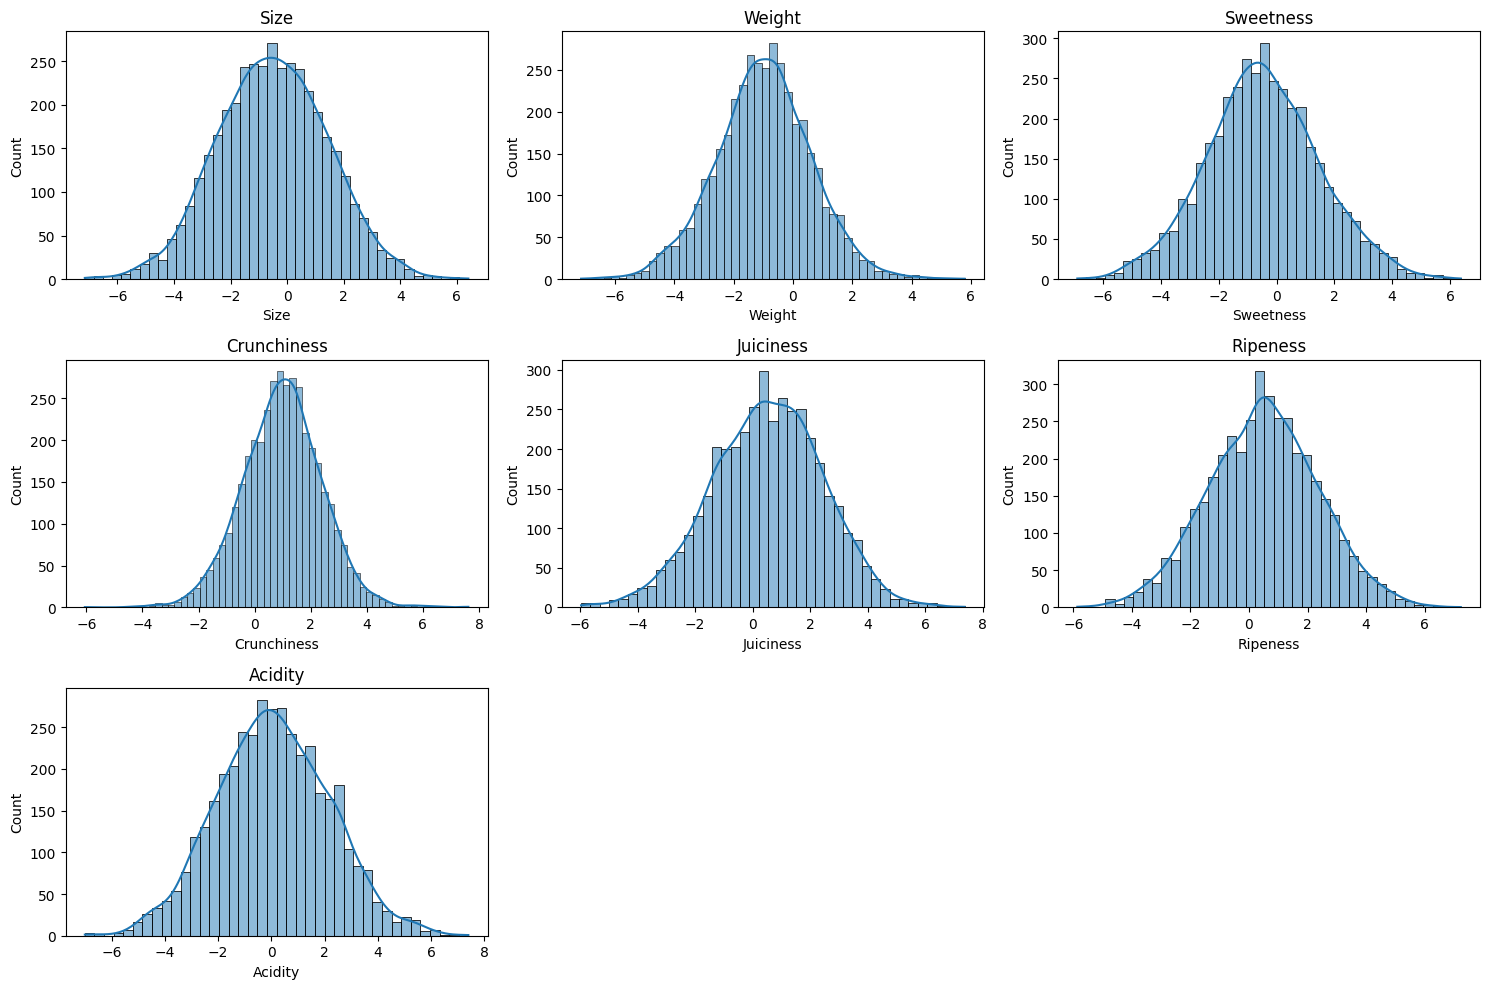

In [4]:
# Visualize numerical features using histograms
numerical_cols = ['Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness', 'Ripeness', 'Acidity']
plt.figure(figsize=(15, 10))
sns.set_palette("tab10")

for i, column in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data=df_clean, x=column, kde=True)
    plt.title(column)

plt.tight_layout()
plt.show()

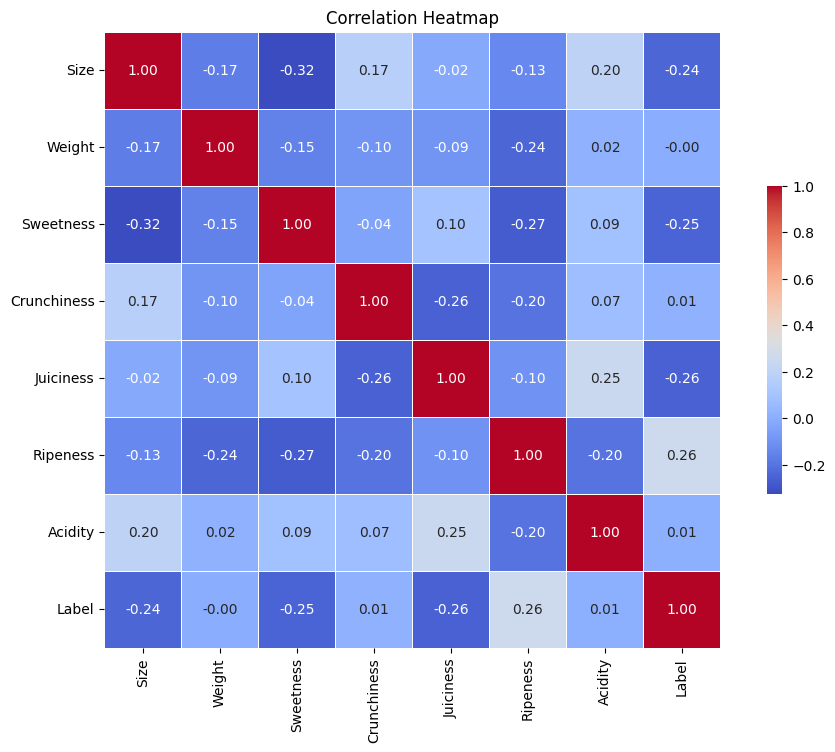

In [5]:
# Visualize correlation using a heatmap
corr_matrix = df_clean.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Heatmap')
plt.show()

In [6]:
# Split data into training and testing sets
X = df_clean.drop('Label', axis=1)
y = df_clean['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=0.95)
pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
print("Number of PCA components chosen:", pca.n_components_)

Number of PCA components chosen: 6


In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, log_loss

# Gradient Boosting Machines (GBM) model
gbm = GradientBoostingRegressor(random_state=42)
gbm.fit(X_train_pca, y_train)
y_pred_gbm = gbm.predict(X_test_pca)

# Convert regression predictions to binary classification labels
y_pred_gbm_binary = np.where(y_pred_gbm >= 0.5, 1, 0)

gbm_accuracy = accuracy_score(y_test, y_pred_gbm_binary)
gbm_precision = precision_score(y_test, y_pred_gbm_binary)
gbm_recall = recall_score(y_test, y_pred_gbm_binary)
gbm_f1 = f1_score(y_test, y_pred_gbm_binary)
gbm_auc_roc = roc_auc_score(y_test, y_pred_gbm)
gbm_log_loss = log_loss(y_test, y_pred_gbm)

# Calculate ROC curve
fpr_gbm, tpr_gbm, thresholds_gbm = roc_curve(y_test, y_pred_gbm)

print("\nMetrics for Gradient Boosting Machines (GBM):")
print("Accuracy:", gbm_accuracy)
print("Precision:", gbm_precision)
print("Recall:", gbm_recall)
print("F1 Score:", gbm_f1)
print("AUC-ROC:", gbm_auc_roc)
print("Log Loss:", gbm_log_loss)

# Neural Networks (MLPRegressor) model
mlp_regressor = MLPRegressor(random_state=42)
mlp_regressor.fit(X_train_pca, y_train)
y_pred_mlp = mlp_regressor.predict(X_test_pca)

# Convert regression predictions to binary classification labels
y_pred_mlp_binary = np.where(y_pred_mlp >= 0.5, 1, 0)

mlp_accuracy = accuracy_score(y_test, y_pred_mlp_binary)
mlp_precision = precision_score(y_test, y_pred_mlp_binary)
mlp_recall = recall_score(y_test, y_pred_mlp_binary)
mlp_f1 = f1_score(y_test, y_pred_mlp_binary)
mlp_auc_roc = roc_auc_score(y_test, y_pred_mlp)
mlp_log_loss = log_loss(y_test, y_pred_mlp)

# Calculate ROC curve
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_test, y_pred_mlp)

print("\nMetrics for Neural Networks (MLPRegressor):")
print("Accuracy:", mlp_accuracy)
print("Precision:", mlp_precision)
print("Recall:", mlp_recall)
print("F1 Score:", mlp_f1)
print("AUC-ROC:", mlp_auc_roc)
print("Log Loss:", mlp_log_loss)

# Random Forest model
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest.fit(X_train_pca, y_train)
y_pred_rf = random_forest.predict(X_test_pca)

# Convert regression predictions to binary classification labels
y_pred_rf_binary = np.where(y_pred_rf >= 0.5, 1, 0)

rf_accuracy = accuracy_score(y_test, y_pred_rf_binary)
rf_precision = precision_score(y_test, y_pred_rf_binary)
rf_recall = recall_score(y_test, y_pred_rf_binary)
rf_f1 = f1_score(y_test, y_pred_rf_binary)
rf_auc_roc = roc_auc_score(y_test, y_pred_rf)
rf_log_loss = log_loss(y_test, y_pred_rf)

# Calculate ROC curve
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)

print("\nMetrics for Random Forest:")
print("Accuracy:", rf_accuracy)
print("Precision:", rf_precision)
print("Recall:", rf_recall)
print("F1 Score:", rf_f1)
print("AUC-ROC:", rf_auc_roc)
print("Log Loss:", rf_log_loss)



Metrics for Gradient Boosting Machines (GBM):
Accuracy: 0.8425
Precision: 0.8428927680798005
Recall: 0.8428927680798005
F1 Score: 0.8428927680798006
AUC-ROC: 0.9203026268914181
Log Loss: 0.4183170669518496

Metrics for Neural Networks (MLPRegressor):
Accuracy: 0.88125
Precision: 0.8787128712871287
Recall: 0.885286783042394
F1 Score: 0.8819875776397517
AUC-ROC: 0.9498684366777292
Log Loss: 0.3442394220556234

Metrics for Random Forest:
Accuracy: 0.85625
Precision: 0.8522167487684729
Recall: 0.8628428927680798
F1 Score: 0.8574969021065676
AUC-ROC: 0.9338683366771042
Log Loss: 0.33608618835571474


## Model Evaluation Summary

Based on the evaluation metrics obtained for the Gradient Boosting Machines (GBM), Neural Networks (MLPRegressor), and Random Forest models, the following observations can be made:

### Accuracy

- GBM: 84.25%
- MLPRegressor: 88.13%
- Random Forest: 85.63%

MLPRegressor performed the best in terms of accuracy among the three models.

### Precision

- GBM: 84.29%
- MLPRegressor: 87.87%
- Random Forest: 85.22%

MLPRegressor had the highest precision score, indicating its ability to minimize false positive predictions.

### Recall

- GBM: 84.29%
- MLPRegressor: 88.53%
- Random Forest: 86.28%

MLPRegressor excelled in capturing a higher proportion of actual positive instances.

### F1 Score

- GBM: 84.29%
- MLPRegressor: 88.20%
- Random Forest: 85.75%

MLPRegressor demonstrated a better balance between precision and recall.

### AUC-ROC

- GBM: 92.03%
- MLPRegressor: 94.99%
- Random Forest: 93.39%

MLPRegressor showed superior performance in classifying instances correctly across different threshold points.

### Log Loss

- GBM: 0.42
- MLPRegressor: 0.34
- Random Forest: 0.34

MLPRegressor exhibited the best calibration of predicted probabilities, resulting in lower log loss.

Overall, MLPRegressor outperformed GBM and Random Forest across most evaluation metrics, indicating its suitability for the classification task. However, further analysis and experimentation may be required to optimize the models further and address any specific requirements or constraints of the application.


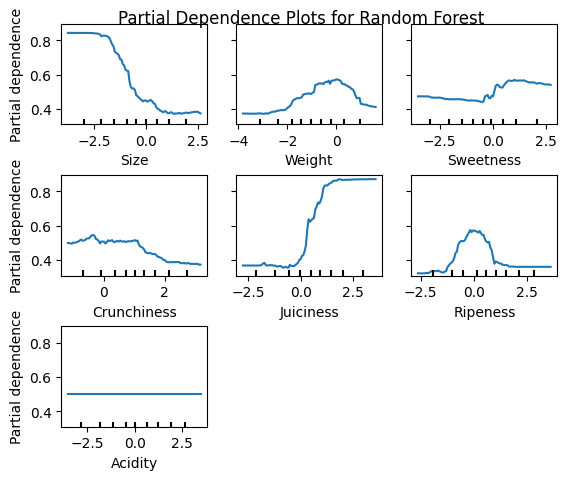

In [8]:
# Partial Dependence Plots for Random Forest
pdp = PartialDependenceDisplay.from_estimator(random_forest, X_test, features=X.columns)
pdp.figure_.suptitle('Partial Dependence Plots for Random Forest')
plt.subplots_adjust(top=0.95, hspace=0.5)
plt.show()

### Summary of Partial Dependence Plots Analysis

#### Size:
- **Representation**: The plot shows a decreasing trend from left to right, with the highest point at approximately (-3, 0.8) and (-1, 0.8), and the lowest point at (2.5, 0.4).
- **Influence**: Larger apples tend to be associated with lower predictions, while smaller apples lead to higher predictions.

#### Weight:
- **Representation**: This plot resembles a small ramp, with the peak at (0, 0.6). The leftmost point is around (-4, 0.5), and the rightmost point is approximately (3, 0.4).
- **Influence**: There is a gradual decrease in predictions as the weight of the apple increases, suggesting that lighter apples are more likely to be associated with higher quality predictions.

#### Sweetness:
- **Representation**: The plot appears to be mostly flat, passing through points (-2.5, 0.5), (0, 0.4), and (2.5, 0.6).
- **Influence**: Sweetness has a relatively minor effect on the model's prediction, with predictions remaining stable across different levels of sweetness.

#### Crunchiness:
- **Representation**: Similar to Sweetness, this plot is mostly flat, decreasing slightly from (-2.5, 0.5) to (3, 0.3).
- **Influence**: Crunchiness has a minimal effect on the model's prediction, with predictions remaining relatively consistent regardless of the level of crunchiness.

#### Juiciness:
- **Representation**: The plot shows an increasing trend from left to right, resembling the first plot but in the mirror. It starts from (-3, 0.3), peaks at (2, 0.9), and (2.5, 0.9).
- **Influence**: Higher levels of juiciness are associated with higher predictions, suggesting that juicier apples are considered of higher quality by the model.

#### Ripeness:
- **Representation**: This plot is also like a small ramp, with a peak at (0, 0.6). It passes through points (-2.5, 0.1), (-2, 0.5), (1, 0.4), and (2.5, 0.2).
- **Influence**: Apples at optimal ripeness are associated with higher predictions, while underripe or overripe apples lead to lower predictions.

#### Acidity:
- **Representation**: The plot is a horizontal line at approximately 0.5.
- **Influence**: Acidity has a neutral effect on the model's prediction, as the predictions remain consistent across different levels of acidity.


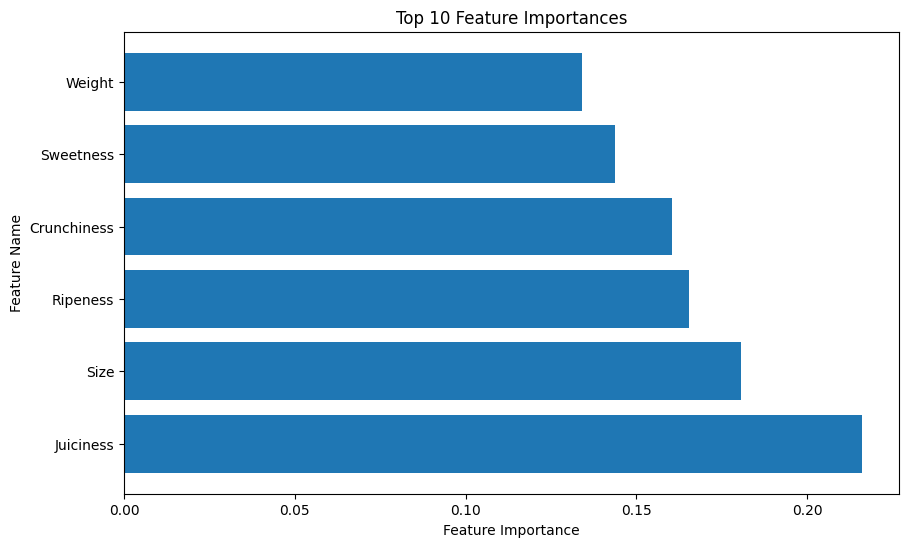

In [9]:
# Calculate feature importances for Random Forest
feat_importances = random_forest.feature_importances_

# Get the indices of the top 10 feature importances
top_indices = np.argsort(feat_importances)[-10:]

# Get the corresponding feature names
top_feat_names = X.columns[top_indices]

# Get the corresponding feature importances
top_feat_importances = feat_importances[top_indices]

# Plot the top 10 feature importances with feature names
plt.figure(figsize=(10, 6))
plt.barh(top_feat_names, top_feat_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important feature at the top
plt.show()


### Analysis of Top 10 Feature Importances

The graph illustrates the top 10 features ranked by their importance in predicting the outcome. Here is a summary of the top features:

1. **Juiciness**: The most important feature, with a feature importance of 0.2, indicating that variations in juiciness have the most significant impact on the model's prediction.

2. **Size**: Ranked second in importance, with a feature importance of 0.175. Size plays a crucial role in predicting the outcome but is slightly less influential than juiciness.

3. **Ripeness**: Ranked third, with a feature importance of 0.16. Ripeness also has a substantial influence on the prediction, slightly lower than size.

4. **Crunchiness**: Ranked fourth, with a feature importance of 0.155. Crunchiness is an essential factor but ranks lower in importance compared to size and ripeness.

5. **Sweetness**: Ranked fifth, with a feature importance of 0.145. Sweetness is also significant in predicting the outcome but ranks lower than juiciness, size, and ripeness.

6. **Weight**: Ranked sixth, with a feature importance of 0.14. Weight contributes to the prediction but is less influential compared to other factors.

The remaining features in the top 10 also contribute to the prediction, but their importance gradually decreases.


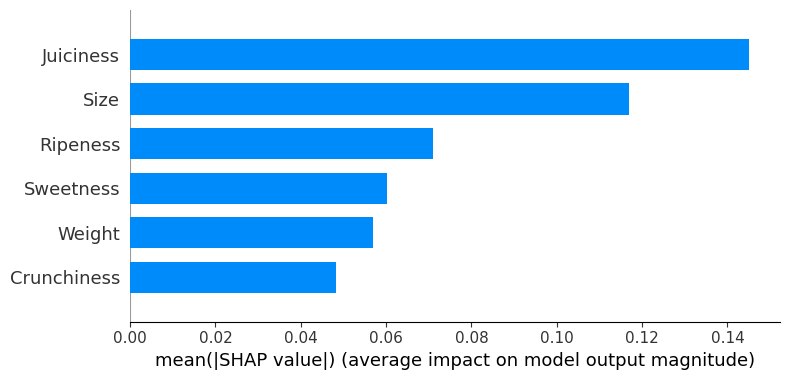

In [10]:
# SHAP (SHapley Additive exPlanations) values for Random Forest
explainer = shap.Explainer(random_forest)
shap_values = explainer.shap_values(X_test_pca)
shap.summary_plot(shap_values, X_test_pca, feature_names=X.columns, plot_type='bar')

### Analysis of SHAP Summary Plot

The SHAP summary plot displays the ranking of features based on their mean absolute SHAP (SHapley Additive exPlanations) values. Here is an analysis of the top features:

1. **Juiciness**: Ranked first, with a mean absolute SHAP value of 0.15. This indicates that variations in juiciness have the highest average impact on the model's output magnitude. Higher levels of juiciness are associated with larger SHAP values, suggesting that juicier apples tend to lead to higher predicted quality scores from the model.

2. **Size**: Ranked second, with a mean absolute SHAP value of 0.12. Size also has a significant impact on the model's output, albeit slightly lower than juiciness. Larger apples tend to have higher SHAP values, indicating that size influences the model's predictions positively by contributing to higher predicted quality scores.

3. **Ripeness**: Ranked third, with a mean absolute SHAP value of 0.07. Ripeness contributes to the model's output, but its impact is lower compared to juiciness and size. Optimal ripeness levels lead to higher SHAP values, suggesting that apples at the right stage of ripeness are associated with higher predicted quality scores.

4. **Sweetness**: Ranked fourth, with a mean absolute SHAP value of 0.06. Sweetness also influences the model's output, although to a lesser extent than juiciness, size, and ripeness. Higher sweetness levels correspond to larger SHAP values, indicating a positive relationship between sweetness and the model's predictions, resulting in higher predicted quality scores.

5. **Weight**: Ranked fifth, with a mean absolute SHAP value of 0.055. Weight contributes to the model's output, but its impact is lower compared to other factors. Heavier apples tend to have slightly higher SHAP values, suggesting that weight plays a modest role in predicting higher quality scores.

6. **Crunchiness**: Ranked sixth, with a mean absolute SHAP value of 0.05. Crunchiness has the least impact among the top features but still contributes to the model's output. Higher levels of crunchiness are associated with marginally higher SHAP values, indicating a modest influence on the model's predictions, resulting in slightly higher predicted quality scores.

Overall, the SHAP summary plot provides insights into how each feature contributes to the model's predictions and helps prioritize features based on their importance.


[LightGBM] [Info] Number of positive: 1595, number of negative: 1605
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 3200, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498437 -> initscore=-0.006250
[LightGBM] [Info] Start training from score -0.006250


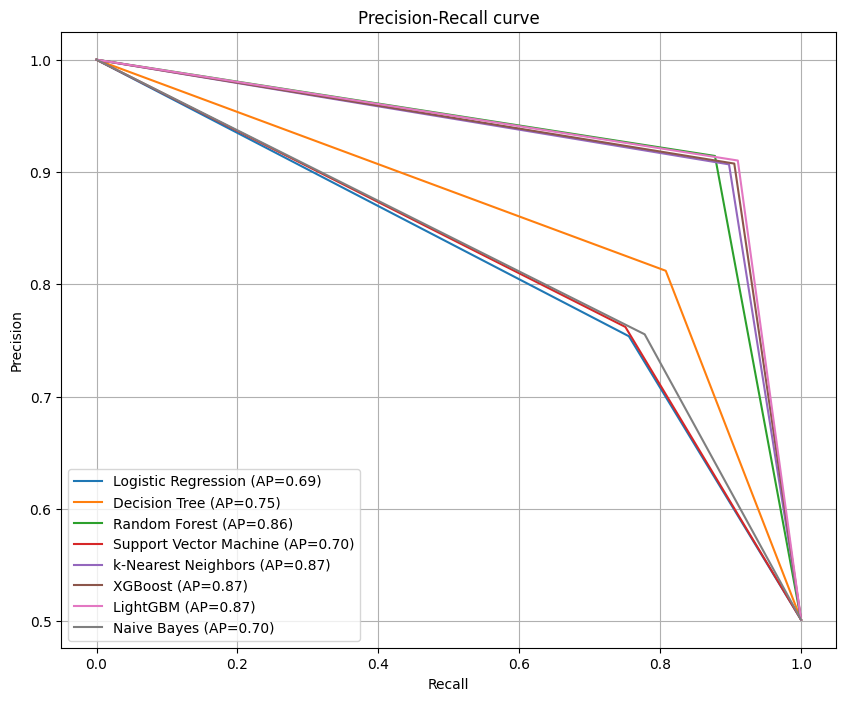

In [11]:
# Compare different classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Support Vector Machine": SVC(kernel='linear', random_state=42),
    "k-Nearest Neighbors": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "Naive Bayes": GaussianNB()
}

results = {}
for name, clf in classifiers.items():
    pipeline = make_pipeline(StandardScaler(), clf)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    average_precision = average_precision_score(y_test, y_pred)
    results[name] = {'Precision': precision, 'Recall': recall, 'Average Precision': average_precision}

# Plot Precision-Recall curves
plt.figure(figsize=(10, 8))
for name, result in results.items():
    plt.plot(result['Recall'], result['Precision'], label=f'{name} (AP={result["Average Precision"]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.grid(True)
plt.show()

### Analysis of Precision-Recall Curves

The precision-recall curves compare the performance of different classifiers based on their precision and recall scores. Here is an analysis of the classifiers and their average precision (AP) values:

1. **Logistic Regression (AP=0.69)**: The precision-recall curve for logistic regression indicates moderate performance, with precision and recall balanced at a lower level.

2. **Decision Tree (AP=0.75)**: The decision tree classifier shows slightly better performance compared to logistic regression, with a higher average precision score.

3. **Random Forest (AP=0.86)**: Random forest exhibits significant improvement in performance, achieving a notably higher average precision score compared to logistic regression and decision tree.

4. **Support Vector Machine (AP=0.70)**: SVM's precision-recall curve suggests performance similar to logistic regression, with moderate precision and recall levels.

5. **k-Nearest Neighbors (AP=0.87)**: k-NN demonstrates excellent performance, with a high average precision score indicating high precision and recall levels.

6. **XGBoost (AP=0.87)**: XGBoost also performs exceptionally well, achieving the same average precision score as k-NN.

7. **LightGBM (AP=0.87)**: LightGBM exhibits performance similar to XGBoost and k-NN, with a high average precision score indicating high precision and recall levels.

8. **Naive Bayes (AP=0.70)**: Naive Bayes shows moderate performance similar to logistic regression and SVM.

Overall, random forest, k-NN, XGBoost, and LightGBM stand out as top performers based on their precision-recall curves, demonstrating high precision and recall levels with notable average precision scores.
